# Setup

## Imports

In [1]:
from IPython.display import display
from helpers import displayAsDF, displayCols, displayVcs, mms, pdp, pie_maker, vcs
import numpy as np
import pandas as pd
import pycountry_convert as pc
import matplotlib.pyplot as plt

## Configuration

In [2]:
pd.options.mode.chained_assignment = None

## Variables

In [3]:
# Downloaded from https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries
salaries = pd.read_csv("ds_salaries.csv", index_col=0)


# Pre-processing

## Preview

In [4]:
salaries

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


## Transformation

### Booleanize `employee_residence` as `ricl`

***Resides In `company_location`**: whether residence is in same country as company*

In [5]:
salaries["ricl"] = salaries["company_location"] == salaries["employee_residence"]
salaries.drop(columns="employee_residence", inplace=True)

displayVcs(salaries["ricl"])

,ricl
False,51
True,556


### `company_location`

- Many discrete values; should be binned to reduce spread.

#### Bin by continents

In [6]:
salaries["company_location"] = salaries["company_location"].apply(pc.country_alpha2_to_continent_code)

displayVcs(salaries["company_location"])

,company_location
AF,4
AS,47
EU,157
NA,389
OC,5
SA,5


#### Integer-ize from West-East

In [7]:
salaries["company_location"].replace({ "NA": 1, "SA": 2, "AF": 3, "EU": 4, "AS": 5, "OC": 6 }, inplace=True)

displayVcs(salaries["company_location"])

,company_location
1,389
2,5
3,4
4,157
5,47
6,5


### Integer-ize `experience_level`

In [8]:
salaries["experience_level"].replace({ "EN": 1, "MI": 2, "SE": 3, "EX": 4 }, inplace=True)

displayVcs(salaries["experience_level"])

,experience_level
1,88
2,213
3,280
4,26


### Integer-ize `company_size`

In [9]:
salaries["company_size"].replace({ "S": 1, "M": 2, "L": 3 }, inplace=True)

displayVcs(salaries["company_size"])

,company_size
1,83
2,326
3,198


### Min-Max Scale Ordinal cols (`company_location`, `company_size`, `experience_level`, & `remote_ratio`)

In [10]:
numeric_cols = ["company_location", "company_size", "experience_level", "remote_ratio"]
salaries[numeric_cols] = mms(salaries[numeric_cols])

salaries[numeric_cols].describe()

,company_location,company_size,experience_level,remote_ratio
count,607.000000,607.000000,607.000000,607.000000
mean,0.229654,0.594728,0.467326,0.709226
std,0.315774,0.327010,0.261837,0.407091
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.333333,0.500000
50%,0.000000,0.500000,0.666667,1.000000
75%,0.600000,1.000000,0.666667,1.000000
max,1.000000,1.000000,1.000000,1.000000


## Cleaning

### Drop `salary` & `salary_currency`

`salary_in_usd` is a standardization (derivative) of those 2 cols

In [11]:
salaries.drop(columns=["salary", "salary_currency"], inplace=True)

displayCols(salaries)

,col
0,work_year
1,experience_level
2,employment_type
3,job_title
4,salary_in_usd
5,remote_ratio
6,company_location
7,company_size
8,ricl


### Duplicates

#### Identify

##### Across index

In [12]:
duplicate_indexes = salaries[salaries.index.duplicated(keep=False)]

display(duplicate_indexes)
print(duplicate_indexes.size)

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size,ricl


0


##### Across values

In [13]:
duplicate_values = vcs(salaries[salaries.duplicated(keep=False)])

displayAsDF(duplicate_values, columns=["duplicates"])
print(duplicate_values.sum())

duplicates
work_year experience_level employment_type job_title                 salary_in_usd remote_ratio company_location company_size ricl            
2021      0.333333         FT              Data Engineer             200000        1.0          0.0              1.0          True           2
                                           Data Scientist            90734         0.5          0.6              1.0          True           2
2022      0.333333         FT              Data Analyst              32974         1.0          0.6              0.5          True           2
                                                                     43966         1.0          0.6              0.5          True           2
                                                                     58000         0.0          0.0              0.0          True           2
                                           Data Engineer             49461         1.0          0.6              0.5          True           2
                                                                     65949         1.0          0.6              0.5          True           2
                                                                     76940         1.0          0.6              0.5          True           2
                                                                     78526         1.0          0.6              0.5          True           2
                                                                     87932         1.0          0.6              0.5          True           2
                                           ETL Developer             54957         0.0          0.6              0.5          True           2
          0.666667         FT              Data Analyst              61300         1.0          0.0              0.5          True           2
                                                                     90320         1.0          0.0              0.5          True           5
                                                                     99000         0.0          0.0              0.5          True           2
                                                                     100000        1.0          0.0              0.5          True           2
                                                                     112900        1.0          0.0              0.5          True           4
                                                                     130000        1.0          0.0              0.5          True           2
                                                                     135000        1.0          0.0              0.5          True           2
                                                                     170000        1.0          0.0              0.5          True           3
                                           Data Engineer             100000        1.0          0.0              0.5          True           2
                                                                     115000        1.0          0.0              0.5          True           2
                                                                     130000        1.0          0.0              0.5          True           2
                                                                     132320        1.0          0.0              0.5          True           2
                                                                     154600        1.0          0.0              1.0          True           2
                                                                     155000        1.0          0.0              0.5          True           2
                                                                     160000        1.0          0.0              0.5          True           2
                                                                     165400        1.0          0.0              0.5          Tr

83


#### Ignore

Based on the available cols, exact duplicates are sensible. They probably refer to employees working for the same company, in the same role.

### Inconsistencies

##### Identify

- `job_title` has lots of different values carrying similar meanings
    - *e.g. Applied Data Scientist, Data Scientist, Lead Data Scientist, ...*

In [14]:
salaries.apply(displayVcs)
pdp()

,work_year
2020,72
2021,217
2022,318


,experience_level
0.000000,88
0.333333,213
0.666667,280
1.000000,26


,employment_type
CT,5
FL,4
FT,588
PT,10


,job_title
3D Computer Vision Researcher,1
AI Scientist,7
Analytics Engineer,4
Applied Data Scientist,5
Applied Machine Learning Scientist,4
BI Data Analyst,6
Big Data Architect,1
Big Data Engineer,8
Business Data Analyst,5
Cloud Data Engineer,2


,salary_in_usd
2859,1
4000,2
5409,1
5679,1
5707,1
...,...
412000,1
416000,1
423000,1
450000,2


,remote_ratio
0.0,127
0.5,99
1.0,381


,company_location
0.0,389
0.2,5
0.4,4
0.6,157
0.8,47
1.0,5


,company_size
0.0,83
0.5,326
1.0,198


,ricl
False,51
True,556


#### `job_title`

##### Standardize

In [15]:
salaries["job_title"].replace(r".*Researcher", "Research Scientist", regex=True, inplace=True)
salaries["job_title"].replace(r"(AI|Computer Vision|Machine Learning|NLP)", "ML", regex=True, inplace=True)
salaries["job_title"].replace(r".*(Data|ML).*(Analyst|Architect|Engineer|Researcher|Scientist).*", r"\1 \2", regex=True, inplace=True)
salaries["job_title"].replace(r"((Director|Head).*|.*(Manager))", "Manager", regex=True, inplace=True)

job_title_vcs = salaries["job_title"].value_counts()
five_pct = salaries.shape[0] / 20
salaries["job_title"][salaries["job_title"].apply(lambda jt: (job_title_vcs[jt] < five_pct))] = "Other"

job_title_vcs = vcs(salaries["job_title"])
displayAsDF(job_title_vcs)

,job_title
Data Analyst,119
Data Engineer,165
Data Scientist,159
ML Engineer,61
Manager,37
Other,66


##### Popularity Encode & Min-Max Scale

In [16]:
salaries["job_title"] = mms(salaries["job_title"].apply(lambda jt: job_title_vcs[jt]))

displayVcs(salaries["job_title"])

,job_title
0.000000,37
0.187500,61
0.226562,66
0.640625,119
0.953125,159
1.000000,165


### Missing Values (NAs)

#### Identify

In [17]:
na_sum = salaries.isna().sum()
# Exclude columns without NAs
na_sum = na_sum[na_sum > 0]

displayAsDF(na_sum, columns=["NAs"])

,NAs


### Outliers

#### Identify

- The difference between `salary_in_usd`'s 3rd quartile & max is huge

In [18]:
salaries.describe()

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000
mean,2021.405272,0.467326,0.690563,112297.869852,0.709226,0.229654,0.594728
std,0.692133,0.261837,0.350267,70957.259411,0.407091,0.315774,0.327010
min,2020.000000,0.000000,0.000000,2859.000000,0.000000,0.000000,0.000000
25%,2021.000000,0.333333,0.226562,62726.000000,0.500000,0.000000,0.500000
50%,2022.000000,0.666667,0.953125,101570.000000,1.000000,0.000000,0.500000
75%,2022.000000,0.666667,1.000000,150000.000000,1.000000,0.600000,1.000000
max,2022.000000,1.000000,1.000000,600000.000000,1.000000,1.000000,1.000000


#### Drop extreme outliers from `salary_in_usd` $(|x-\bar{x}|\le 2\sigma)$

In [19]:
salaries = salaries[np.abs(salaries["salary_in_usd"] - salaries["salary_in_usd"].mean()) <= (2 * salaries["salary_in_usd"].std())]

displayAsDF(salaries["salary_in_usd"].describe())

,salary_in_usd
count,591.000000
mean,105569.216582
std,56640.165128
min,2859.000000
25%,61948.000000
50%,100000.000000
75%,145000.000000
max,250000.000000


### Low Variance $(\text{Biggest group pct}>95\%)$

#### Identify

- `employment_type` is dominated by "FT"

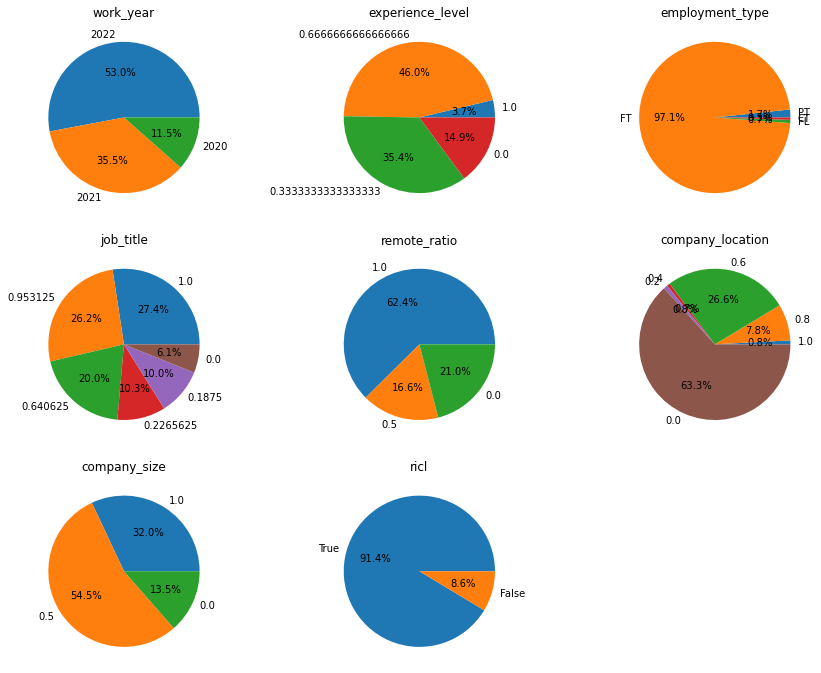

In [20]:
lv_X_cols = salaries.columns.drop("salary_in_usd")
salaries[lv_X_cols].apply(pie_maker(lv_X_cols.size, 3))
plt.show()

#### Drop

Cols w/ Low Variance will not help w/ Modelling

In [21]:
lv_cols = ["employment_type"]

salaries.drop(columns=lv_cols, inplace=True)

displayCols(salaries)

,col
0,work_year
1,experience_level
2,job_title
3,salary_in_usd
4,remote_ratio
5,company_location
6,company_size
7,ricl


## Feature Selection

### Correlation Analysis

There are no strongly correlated cols

In [22]:
pearson = salaries.corr()
spearman = salaries.corr("spearman")

display(pearson.style.background_gradient(cmap="Reds"))
display(spearman.style.background_gradient(cmap="Reds"))

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size,ricl
work_year,1.000000,0.313639,0.038805,0.289007,0.067835,-0.277007,-0.080334,0.150223
experience_level,0.313639,1.000000,-0.045435,0.530218,0.089189,-0.352263,0.066641,0.066975
job_title,0.038805,-0.045435,1.000000,-0.031816,-0.002138,-0.044115,0.027657,0.051363
salary_in_usd,0.289007,0.530218,-0.031816,1.000000,0.143515,-0.559875,0.140546,0.156454
remote_ratio,0.067835,0.089189,-0.002138,0.143515,1.000000,-0.189412,-0.029430,-0.095203
company_location,-0.277007,-0.352263,-0.044115,-0.559875,-0.189412,1.000000,-0.030970,-0.054020
company_size,-0.080334,0.066641,0.027657,0.140546,-0.029430,-0.030970,1.000000,0.087340
ricl,0.150223,0.066975,0.051363,0.156454,-0.095203,-0.054020,0.087340,1.000000


,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size,ricl
work_year,1.000000,0.326109,0.049796,0.314161,0.118829,-0.295773,-0.153242,0.166178
experience_level,0.326109,1.000000,-0.018562,0.557575,0.121280,-0.373028,0.027687,0.071662
job_title,0.049796,-0.018562,1.000000,0.010792,0.033261,-0.019441,0.038068,0.020372
salary_in_usd,0.314161,0.557575,0.010792,1.000000,0.179842,-0.595832,0.109380,0.166981
remote_ratio,0.118829,0.121280,0.033261,0.179842,1.000000,-0.237075,-0.059444,-0.089400
company_location,-0.295773,-0.373028,-0.019441,-0.595832,-0.237075,1.000000,-0.011855,-0.050173
company_size,-0.153242,0.027687,0.038068,0.109380,-0.059444,-0.011855,1.000000,0.070885
ricl,0.166178,0.071662,0.020372,0.166981,-0.089400,-0.050173,0.070885,1.000000


# Exports

In [23]:
from joblib import dump

In [24]:
dump(salaries, "salaries.pkl")

['salaries.pkl']

In [25]:
def Mapper(keys, series):
  mapper = {}
  for i, v in enumerate(sorted(series.unique())):
    mapper[keys[i]] = v
  return mapper

mappers = {
  "company_location": Mapper(["NA", "SA", "AF", "EU", "AS", "OC"], salaries["company_location"]),
  "company_size": Mapper(["S", "M", "L"], salaries["company_size"]),
  "experience_level": Mapper(["EN", "MI", "SE", "EX"], salaries["experience_level"]),
  "job_title": Mapper(["Manager", "ML Engineer", "Other", "Data Analyst", "Data Scientist", "Data Engineer"], salaries["job_title"])
}

dump(mappers, "../mappers.pkl")

['../mappers.pkl']